In [ ]:
# Set a time the time span of interest
# Read station file to parse the coordinates of stations
# Iterate over L2 products to extract chl-a values at stations
# Add chl-a value to a table with stations/dates
# Plot or produce data output

In [ ]:
# https://stackoverflow.com/questions/52293759/snappy-wrong-conversion-from-pixel-to-lat-long
# https://forum.step.esa.int/t/extracting-pixel-values-sentinel-2a-l2a-with-snap-or-snappy/29878/4

In [1]:
import os
import zipfile
import numpy as np
from PIL import Image
from datetime import date
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
from datetime import date, timedelta
import shutil


from snappy import ProductIO, GPF, HashMap, ProductUtils, PixelPos, GeoPos, ProductData, jpy
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt, make_path_filter

%matplotlib inline

INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
Currently installed 9.0.0, available is 10.0.0.
Please visit http://step.esa.int



In [2]:
S3_ROOT_FOLDER = Path('/home/jovyan/earth-observations/notebooks')
ROI = ""
YEAR = ""
MONTH = ""

In [3]:
def read_BEAM(filename):
    reader = ProductIO.getProductReader('BEAM-DIMAP')
    return ProductIO.readProduct(filename)

FILENAME = "./moutput.nc.dim"
p = read_BEAM(FILENAME)

In [5]:
print(list(p.getBandNames()))

['longitude', 'latitude', 'quality_flags', 'rtoa_1', 'rtoa_2', 'rtoa_3', 'rtoa_4', 'rtoa_5', 'rtoa_6', 'rtoa_7', 'rtoa_8', 'rtoa_9', 'rtoa_10', 'rtoa_11', 'rtoa_12', 'rtoa_13', 'rtoa_14', 'rtoa_15', 'rtoa_16', 'rtoa_17', 'rtoa_18', 'rtoa_19', 'rtoa_20', 'rtoa_21', 'rtosa_gc_1', 'rtosa_gc_2', 'rtosa_gc_3', 'rtosa_gc_4', 'rtosa_gc_5', 'rtosa_gc_6', 'rtosa_gc_7', 'rtosa_gc_8', 'rtosa_gc_9', 'rtosa_gc_10', 'rtosa_gc_11', 'rtosa_gc_12', 'rtosa_gc_16', 'rtosa_gc_17', 'rtosa_gc_18', 'rtosa_gc_21', 'rtosagc_aann_1', 'rtosagc_aann_2', 'rtosagc_aann_3', 'rtosagc_aann_4', 'rtosagc_aann_5', 'rtosagc_aann_6', 'rtosagc_aann_7', 'rtosagc_aann_8', 'rtosagc_aann_9', 'rtosagc_aann_10', 'rtosagc_aann_11', 'rtosagc_aann_12', 'rtosagc_aann_16', 'rtosagc_aann_17', 'rtosagc_aann_18', 'rtosagc_aann_21', 'rpath_1', 'rpath_2', 'rpath_3', 'rpath_4', 'rpath_5', 'rpath_6', 'rpath_7', 'rpath_8', 'rpath_9', 'rpath_10', 'rpath_11', 'rpath_12', 'rpath_16', 'rpath_17', 'rpath_18', 'rpath_21', 'tdown_1', 'tdown_2', 'tdo

In [21]:
def coords_from_xy(geocode, x, y):
    geoPos = geocode.getGeoPos(PixelPos(x, y), None)
    lat = geoPos.getLat()
    lon = geoPos.getLon()
    
    return lat, lon

def xy_from_coords(geocode, lat, lon):
    pixelPos = geocode.getPixelPos(GeoPos(lat, lon), None)
    x = np.round(pixelPos.getX())
    y = np.round(pixelPos.getY())
    
    return x, y

In [22]:
sg = p.getSceneGeoCoding()

lat = 59.872789
lon = 10.656834
 
x, y = xy_from_coords(sg, lat, lon)
print(x, y)
print(coords_from_xy(sg, x, y))

60.0 40.0
(59.872676, 10.658605)


In [23]:
def get_chl_from_lat_lon(product, lat, lon):
    
    sg = product.getSceneGeoCoding()
    try:
        x, y = xy_from_coords(sg, lat, lon)
    except ValueError:
        print("Coordinates are outside the region of interest")
        return
    
    raw_chl_value = product.getBand('iop_apig').readPixels(int(x), int(y), 1, 1, np.zeros(1))
    return np.power(raw_chl_value, 1.04) * 21  # Default values from SNAP
    

In [24]:
get_chl_from_lat_lon(p, 59.872789, 10.656834)

array([24.14604536])

In [25]:
p.getBand('iop_apig').readPixels(int(x), int(y), 1, 1, np.zeros(1))

array([1.1436547])

In [26]:
def plotBand(product, band):
     
    band = product.getBand(band)

    w = band.getRasterWidth()
    h = band.getRasterHeight()

    band_data = np.zeros(w * h, np.float32)
    band.readPixels(0, 0, w, h, band_data)

    band_data.shape = h, w

    width = 12
    height = 12
    plt.figure(figsize=(width, height))
    imgplot = plt.imshow(band_data, cmap=plt.cm.binary)
    
    return  

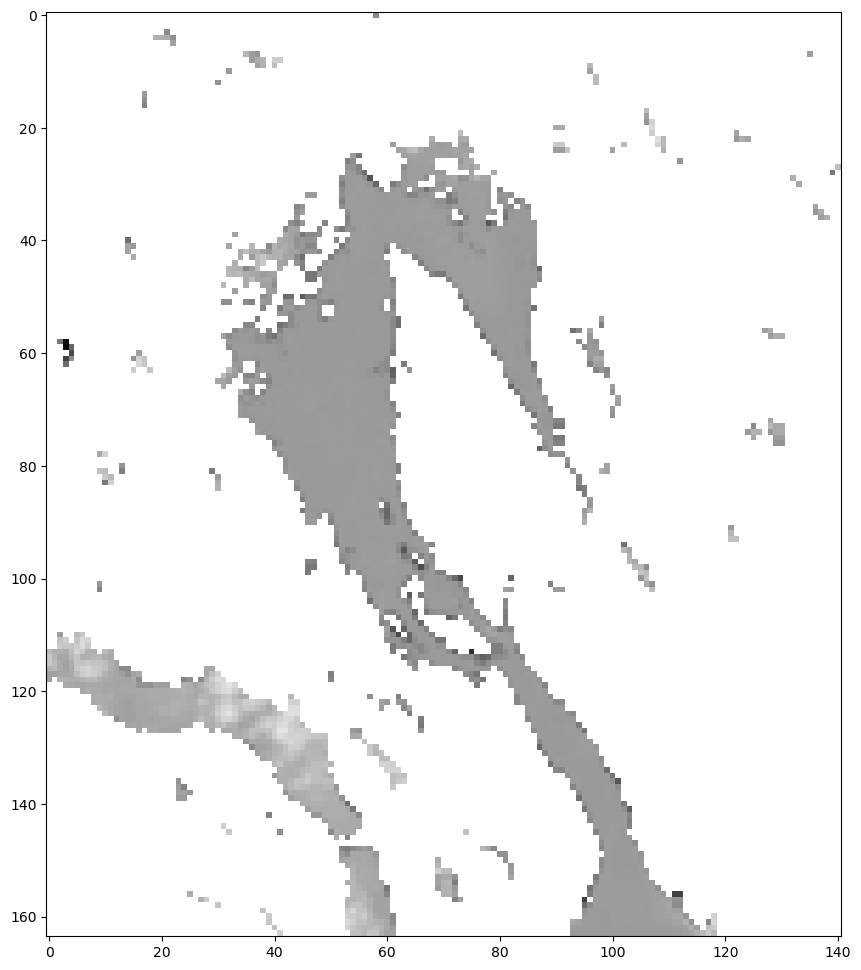

In [27]:
plotBand(p, 'iop_apig')